# MegaScale Dataset Exploration

Exploring the MegaScale dataset for protein stability (ΔΔG) prediction.

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
from collections import Counter
from datasets import load_dataset

from src.data.dataset import MegaScaleDataset, parse_mutation, get_wt_sequence

/Users/juliankoh/Desktop/_Organized/Projects/chai-thermo/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [2]:
# Load raw dataset from HuggingFace
ds_raw = load_dataset('RosettaCommons/MegaScale', 'dataset3_single_cv')
print(ds_raw)

DatasetDict({
    train_0: Dataset({
        features: ['name', 'dna_seq', 'log10_K50_t', 'log10_K50_t_95CI_high', 'log10_K50_t_95CI_low', 'log10_K50_t_95CI', 'fitting_error_t', 'log10_K50unfolded_t', 'deltaG_t', 'deltaG_t_95CI_high', 'deltaG_t_95CI_low', 'deltaG_t_95CI', 'log10_K50_c', 'log10_K50_c_95CI_high', 'log10_K50_c_95CI_low', 'log10_K50_c_95CI', 'fitting_error_c', 'log10_K50unfolded_c', 'deltaG_c', 'deltaG_c_95CI_high', 'deltaG_c_95CI_low', 'deltaG_c_95CI', 'deltaG', 'deltaG_95CI_high', 'deltaG_95CI_low', 'deltaG_95CI', 'aa_seq_full', 'aa_seq', 'mut_type', 'WT_name', 'WT_cluster', 'log10_K50_trypsin_ML', 'log10_K50_chymotrypsin_ML', 'dG_ML', 'ddG_ML', 'Stabilizing_mut', 'pair_name'],
        num_rows: 164094
    })
    train_1: Dataset({
        features: ['name', 'dna_seq', 'log10_K50_t', 'log10_K50_t_95CI_high', 'log10_K50_t_95CI_low', 'log10_K50_t_95CI', 'fitting_error_t', 'log10_K50unfolded_t', 'deltaG_t', 'deltaG_t_95CI_high', 'deltaG_t_95CI_low', 'deltaG_t_95CI', 'log10_

In [3]:
# Load our wrapped dataset
train_ds = MegaScaleDataset(fold=0, split='train')
val_ds = MegaScaleDataset(fold=0, split='val')
test_ds = MegaScaleDataset(fold=0, split='test')

print(f"Fold 0 sizes:")
print(f"  Train: {len(train_ds):,}")
print(f"  Val:   {len(val_ds):,}")
print(f"  Test:  {len(test_ds):,}")

Fold 0 sizes:
  Train: 164,094
  Val:   55,592
  Test:  51,545


## Fold Statistics

In [4]:
# Stats across all folds
fold_stats = []
for fold in range(5):
    for split in ['train', 'val', 'test']:
        key = f"{split}_{fold}"
        n_samples = len(ds_raw[key])
        n_proteins = len(set(ds_raw[key]['WT_name']))
        fold_stats.append({
            'fold': fold,
            'split': split,
            'n_samples': n_samples,
            'n_proteins': n_proteins
        })

fold_df = pd.DataFrame(fold_stats)
fold_df.pivot(index='fold', columns='split', values=['n_samples', 'n_proteins'])

n_samples                n_proteins          
split      test   train    val       test train val
fold                                               
0         51545  164094  55592         51   188  59
1         55592  160686  54953         59   176  63
2         54953  161791  54487         63   172  63
3         54487  162090  54654         63   173  62
4         54654  165032  51545         62   185  51

## Sample Data

In [5]:
# Look at a few samples
for i in [0, 100, 1000]:
    sample = train_ds[i]
    print(f"Sample {i}:")
    print(f"  Protein: {sample.wt_name}")
    print(f"  Mutation: {sample.wt_residue}{sample.position+1}{sample.mut_residue}")
    print(f"  ΔΔG: {sample.ddg:.3f} kcal/mol")
    print(f"  Sequence ({len(sample.wt_sequence)} aa): {sample.wt_sequence[:40]}...")
    print()

Sample 0:
  Protein: r10_437_TrROS_Hall.pdb
  Mutation: E1Q
  ΔΔG: -0.295 kcal/mol
  Sequence (47 aa): EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEV...

Sample 100:
  Protein: r10_437_TrROS_Hall.pdb
  Mutation: F6R
  ΔΔG: 0.944 kcal/mol
  Sequence (47 aa): EPELVFKVRVRTKDGRELEIEVSAEDLEKLLEALPDIEEV...

Sample 1000:
  Protein: r11_569_TrROS_Hall.pdb
  Mutation: E7M
  ΔΔG: -0.474 kcal/mol
  Sequence (49 aa): MKVTIEENEETGKFTIKVKTEDGEEKTIEIPKENLEEILA...



## ΔΔG Distribution

**IMPORTANT: Sign Convention Discovery**

MegaScale uses an **inverted** sign convention:
- Raw data: ΔΔG = ΔG(WT) - ΔG(mutant) → **positive = stabilizing**
- Standard: ΔΔG = ΔG(mutant) - ΔG(WT) → **positive = destabilizing**

Evidence: `Stabilizing_mut=True` entries have **positive** ddG values in raw data.

Our `MegaScaleDataset` class **flips the sign** to standard convention.

In [6]:
# Get all ddG values
train_raw = ds_raw['train_0']
ddgs = np.array(train_raw['ddG_ML'])

print("ΔΔG Statistics:")
print(f"  Count: {len(ddgs):,}")
print(f"  Mean:  {ddgs.mean():.3f} kcal/mol")
print(f"  Std:   {ddgs.std():.3f} kcal/mol")
print(f"  Min:   {ddgs.min():.3f} kcal/mol")
print(f"  Max:   {ddgs.max():.3f} kcal/mol")
print()
print("Percentiles:")
for p in [1, 5, 25, 50, 75, 95, 99]:
    print(f"  {p:2d}%: {np.percentile(ddgs, p):6.3f}")

ΔΔG Statistics:
  Count: 164,094
  Mean:  -0.757 kcal/mol
  Std:   1.009 kcal/mol
  Min:   -5.663 kcal/mol
  Max:   2.750 kcal/mol

Percentiles:
   1%: -3.862
   5%: -2.746
  25%: -1.282
  50%: -0.516
  75%: -0.045
  95%:  0.463
  99%:  0.938


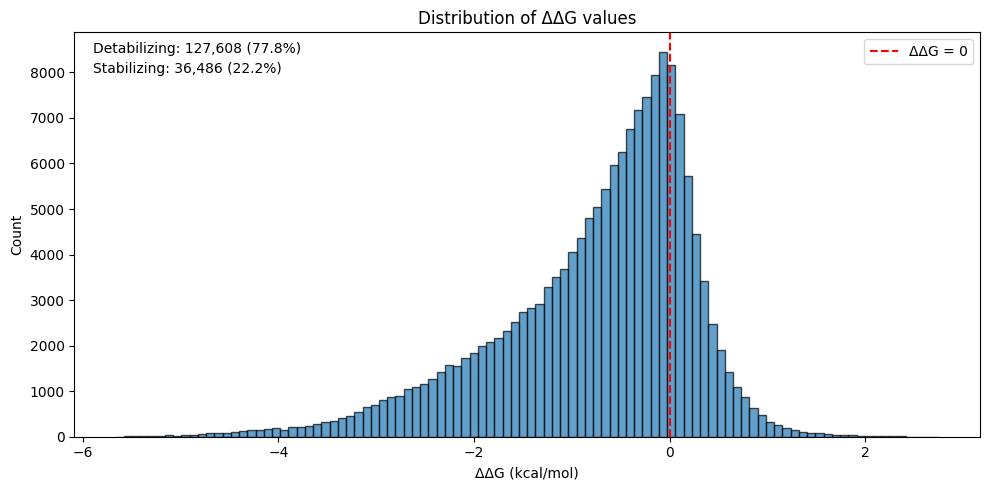

In [8]:
# Histogram
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ddgs, bins=100, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', label='ΔΔG = 0')
ax.set_xlabel('ΔΔG (kcal/mol)')
ax.set_ylabel('Count')
ax.set_title('Distribution of ΔΔG values')
ax.legend()

# Add annotations
stabilizing = (ddgs < 0).sum()
destabilizing = (ddgs > 0).sum()
ax.annotate(f'Detabilizing: {stabilizing:,} ({100*stabilizing/len(ddgs):.1f}%)', 
            xy=(0.02, 0.95), xycoords='axes fraction')
ax.annotate(f'Stabilizing: {destabilizing:,} ({100*destabilizing/len(ddgs):.1f}%)', 
            xy=(0.02, 0.90), xycoords='axes fraction')

plt.tight_layout()
plt.show()

In [9]:
# Verify sign convention with Stabilizing_mut field
flags = train_raw['Stabilizing_mut']

print("=== Verifying Sign Convention ===")
for flag_val in ['True', 'False', '-']:
    mask = [f == flag_val for f in flags]
    subset = ddgs[mask]
    if len(subset) > 0:
        print(f"Stabilizing_mut={flag_val!r:8s}: n={len(subset):6d}, raw ddG mean={subset.mean():+.3f}")

print("\nConclusion: Stabilizing_mut=True has POSITIVE mean ddG in raw data")
print("=> MegaScale uses inverted convention. Our dataset wrapper flips the sign.")

=== Verifying Sign Convention ===
Stabilizing_mut='True'  : n=   923, raw ddG mean=+1.392
Stabilizing_mut='False' : n=128790, raw ddG mean=-1.040
Stabilizing_mut='-'     : n= 34381, raw ddG mean=+0.246

Conclusion: Stabilizing_mut=True has POSITIVE mean ddG in raw data
=> MegaScale uses inverted convention. Our dataset wrapper flips the sign.


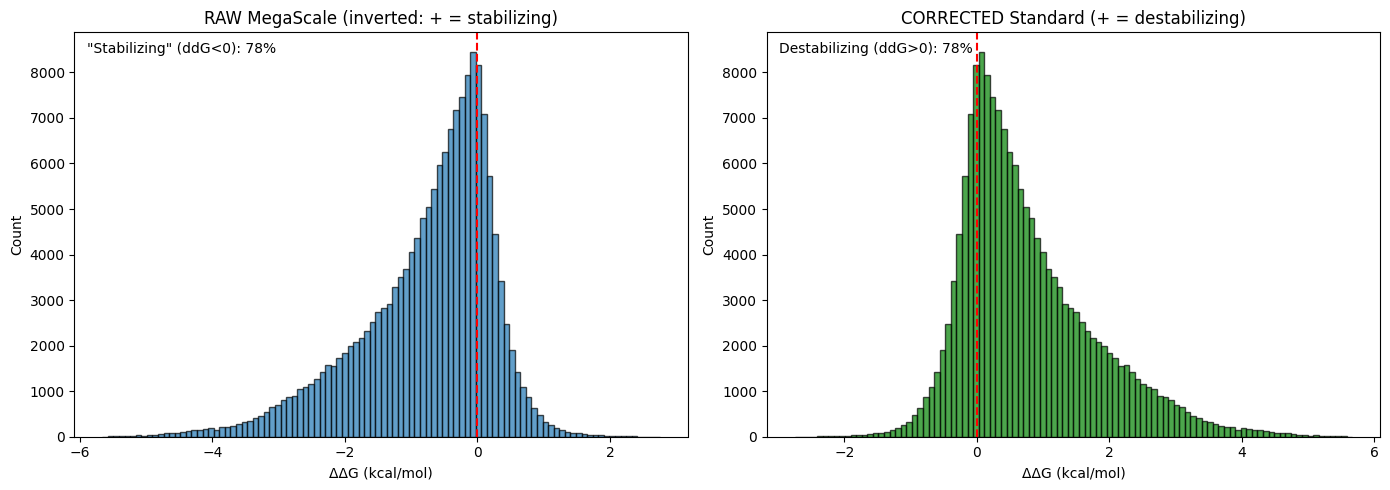


Corrected stats: mean=0.757, range=[-2.75, 5.66]


In [10]:
# Corrected distribution using our dataset wrapper (sign flipped to standard convention)
ddgs_corrected = np.array([train_ds[i].ddg for i in range(len(train_ds))])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw (inverted) distribution
axes[0].hist(ddgs, bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--')
axes[0].set_xlabel('ΔΔG (kcal/mol)')
axes[0].set_ylabel('Count')
axes[0].set_title('RAW MegaScale (inverted: + = stabilizing)')
stab_raw = (ddgs < 0).sum()
axes[0].annotate(f'"Stabilizing" (ddG<0): {100*stab_raw/len(ddgs):.0f}%', xy=(0.02, 0.95), xycoords='axes fraction')

# Corrected (standard) distribution  
axes[1].hist(ddgs_corrected, bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('ΔΔG (kcal/mol)')
axes[1].set_ylabel('Count')
axes[1].set_title('CORRECTED Standard (+ = destabilizing)')
destab = (ddgs_corrected > 0).sum()
axes[1].annotate(f'Destabilizing (ddG>0): {100*destab/len(ddgs_corrected):.0f}%', xy=(0.02, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()

print(f"\nCorrected stats: mean={ddgs_corrected.mean():.3f}, range=[{ddgs_corrected.min():.2f}, {ddgs_corrected.max():.2f}]")

## Protein Statistics

In [11]:
# WT sequence stats
wt_seqs = train_ds.wt_sequences
lengths = [len(seq) for seq in wt_seqs.values()]

print(f"Unique proteins: {len(wt_seqs)}")
print(f"Sequence lengths: {min(lengths)}-{max(lengths)} aa")
print(f"Mean length: {np.mean(lengths):.1f} aa")

Unique proteins: 188
Sequence lengths: 32-72 aa
Mean length: 49.1 aa


In [12]:
# Mutations per protein
mutations_per_protein = Counter(train_raw['WT_name'])
counts = list(mutations_per_protein.values())

print(f"Mutations per protein:")
print(f"  Min:  {min(counts)}")
print(f"  Max:  {max(counts)}")
print(f"  Mean: {np.mean(counts):.1f}")
print()
print("Top 10 proteins by mutation count:")
for name, count in mutations_per_protein.most_common(10):
    seq_len = len(wt_seqs.get(name, ''))
    print(f"  {name}: {count} mutations ({seq_len} aa)")

Mutations per protein:
  Min:  448
  Max:  1353
  Mean: 872.8

Top 10 proteins by mutation count:
  1UFM.pdb: 1353 mutations (72 aa)
  2M2J.pdb: 1346 mutations (71 aa)
  2L33.pdb: 1329 mutations (71 aa)
  5KPH.pdb: 1287 mutations (69 aa)
  1QKH.pdb: 1267 mutations (68 aa)
  2JT1.pdb: 1264 mutations (67 aa)
  2MA4.pdb: 1238 mutations (70 aa)
  2KFV.pdb: 1237 mutations (69 aa)
  2K5N.pdb: 1236 mutations (67 aa)
  6M3N.pdb: 1215 mutations (64 aa)


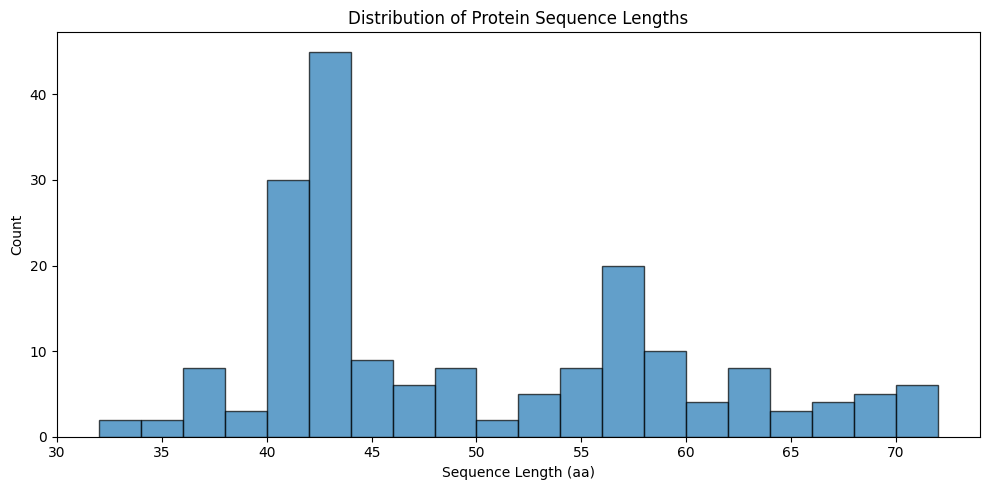

In [13]:
# Sequence length histogram
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(lengths, bins=20, edgecolor='black', alpha=0.7)
ax.set_xlabel('Sequence Length (aa)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Protein Sequence Lengths')
plt.tight_layout()
plt.show()

## Amino Acid Mutation Patterns

In [14]:
# Parse all mutations
mut_types = train_raw['mut_type']
parsed = [parse_mutation(m) for m in mut_types]

wt_aas = [p[0] for p in parsed]
mut_aas = [p[2] for p in parsed]

print("WT amino acid distribution:")
wt_counts = Counter(wt_aas)
for aa, count in sorted(wt_counts.items(), key=lambda x: -x[1])[:10]:
    print(f"  {aa}: {count:,} ({100*count/len(wt_aas):.1f}%)")

WT amino acid distribution:
  E: 18,802 (11.5%)
  K: 18,153 (11.1%)
  L: 12,768 (7.8%)
  A: 11,943 (7.3%)
  V: 11,422 (7.0%)
  T: 10,831 (6.6%)
  R: 9,363 (5.7%)
  G: 9,306 (5.7%)
  D: 8,944 (5.5%)
  I: 8,361 (5.1%)


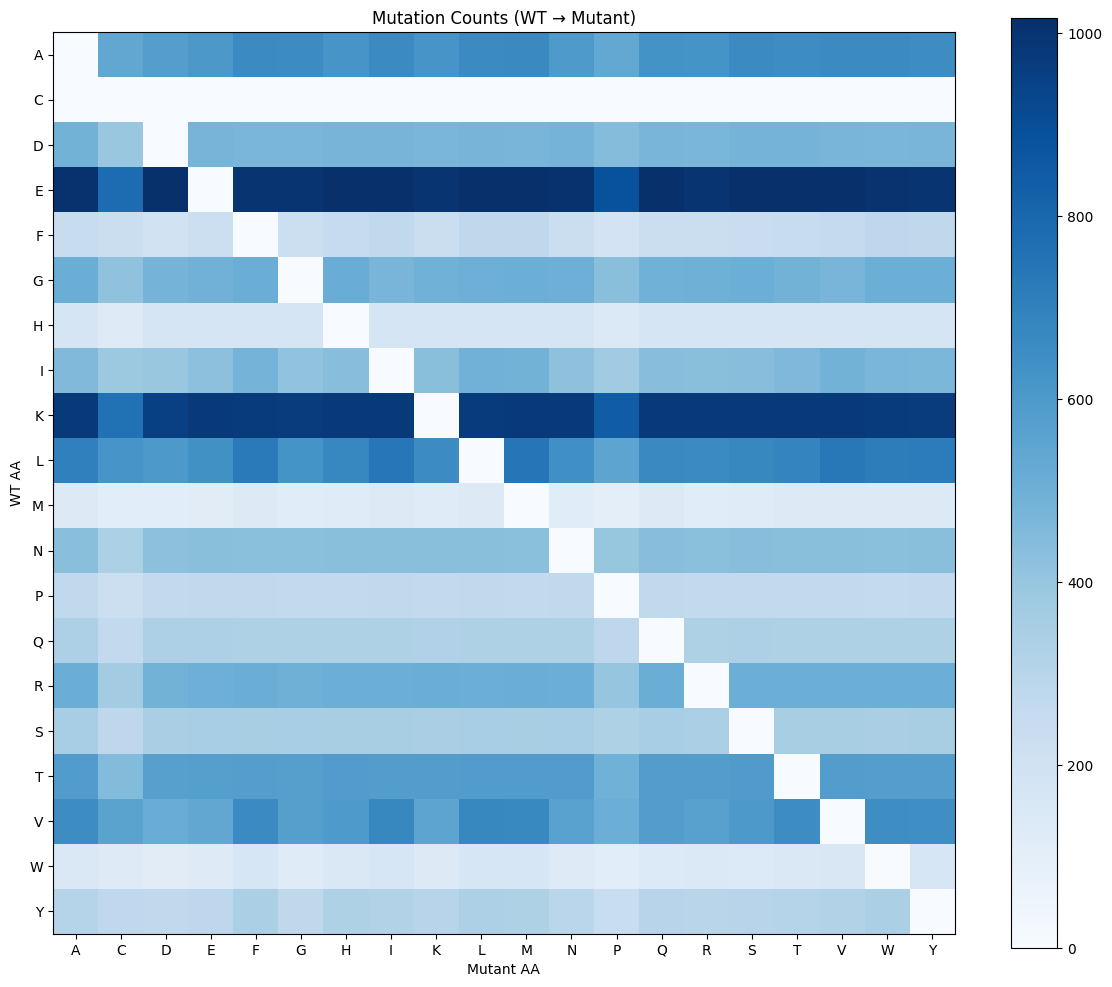

In [15]:
# Mutation matrix (WT -> Mut counts)
AA_ORDER = 'ACDEFGHIKLMNPQRSTVWY'
mut_matrix = np.zeros((20, 20), dtype=int)

for wt, mut in zip(wt_aas, mut_aas):
    if wt in AA_ORDER and mut in AA_ORDER:
        i = AA_ORDER.index(wt)
        j = AA_ORDER.index(mut)
        mut_matrix[i, j] += 1

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(mut_matrix, cmap='Blues')
ax.set_xticks(range(20))
ax.set_yticks(range(20))
ax.set_xticklabels(list(AA_ORDER))
ax.set_yticklabels(list(AA_ORDER))
ax.set_xlabel('Mutant AA')
ax.set_ylabel('WT AA')
ax.set_title('Mutation Counts (WT → Mutant)')
plt.colorbar(im)
plt.tight_layout()
plt.show()

## Cysteine Analysis

In [16]:
# Cysteine mutations (potential artifacts)
ddgs_array = np.array(train_raw['ddG_ML'])

to_cys_idx = [i for i, m in enumerate(mut_aas) if m == 'C']
from_cys_idx = [i for i, w in enumerate(wt_aas) if w == 'C']
no_cys_idx = [i for i in range(len(wt_aas)) if wt_aas[i] != 'C' and mut_aas[i] != 'C']

print(f"Mutations TO Cys:   {len(to_cys_idx):,} - mean ΔΔG: {ddgs_array[to_cys_idx].mean():.3f}")
print(f"Mutations FROM Cys: {len(from_cys_idx):,} - mean ΔΔG: {ddgs_array[from_cys_idx].mean():.3f}")
print(f"No Cys involved:    {len(no_cys_idx):,} - mean ΔΔG: {ddgs_array[no_cys_idx].mean():.3f}")

Mutations TO Cys:   7,217 - mean ΔΔG: -0.307
Mutations FROM Cys: 19 - mean ΔΔG: -0.626
No Cys involved:    156,858 - mean ΔΔG: -0.778


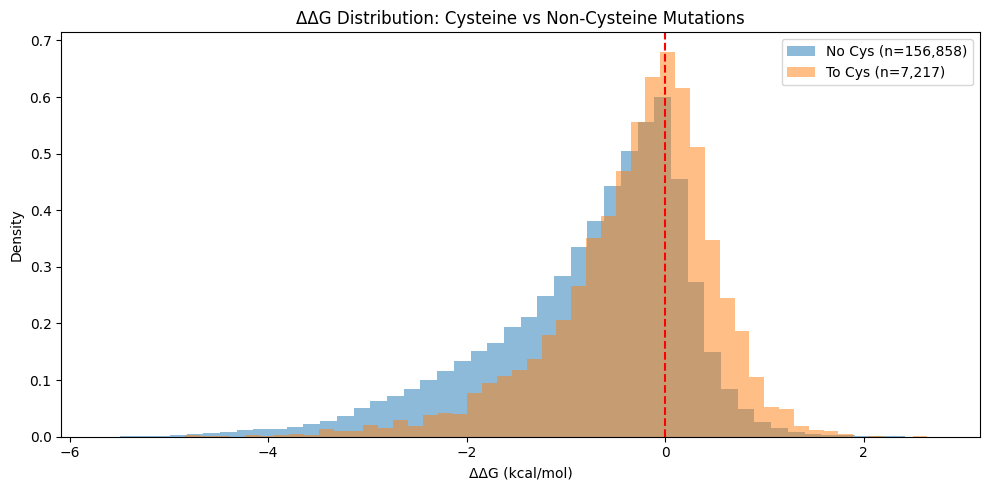

In [17]:
# Compare distributions
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(ddgs_array[no_cys_idx], bins=50, alpha=0.5, label=f'No Cys (n={len(no_cys_idx):,})', density=True)
ax.hist(ddgs_array[to_cys_idx], bins=50, alpha=0.5, label=f'To Cys (n={len(to_cys_idx):,})', density=True)

ax.axvline(0, color='red', linestyle='--')
ax.set_xlabel('ΔΔG (kcal/mol)')
ax.set_ylabel('Density')
ax.set_title('ΔΔG Distribution: Cysteine vs Non-Cysteine Mutations')
ax.legend()
plt.tight_layout()
plt.show()

## Position Analysis

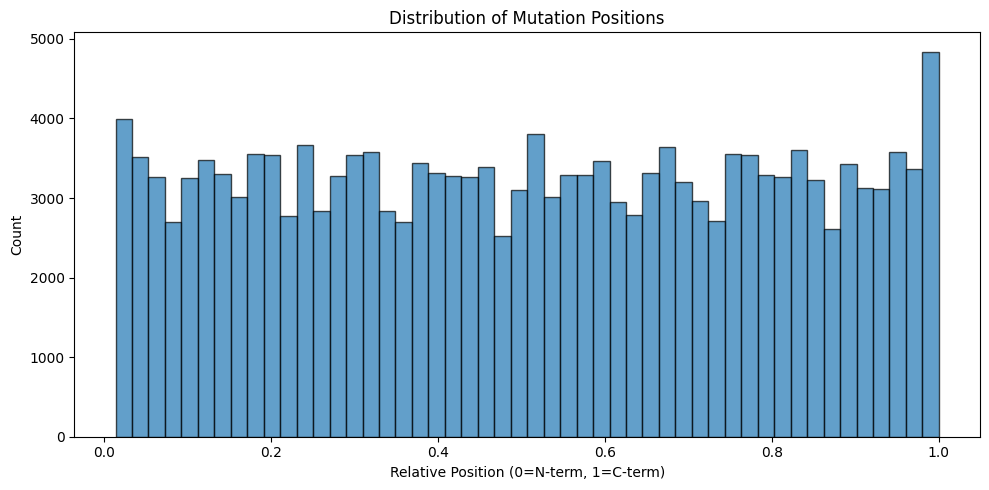

In [18]:
# Relative position analysis
positions = [p[1] for p in parsed]  # 1-indexed positions

# Get sequence lengths for each mutation
seq_lens = [len(wt_seqs.get(name, '')) for name in train_raw['WT_name']]
rel_positions = [pos / seq_len if seq_len > 0 else 0 for pos, seq_len in zip(positions, seq_lens)]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(rel_positions, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Relative Position (0=N-term, 1=C-term)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Mutation Positions')
plt.tight_layout()
plt.show()

## Per-Protein ΔΔG Statistics

In [19]:
# Calculate per-protein statistics
protein_stats = []
for name in set(train_raw['WT_name']):
    mask = [n == name for n in train_raw['WT_name']]
    protein_ddgs = ddgs_array[mask]
    protein_stats.append({
        'name': name,
        'n_mutations': len(protein_ddgs),
        'mean_ddg': protein_ddgs.mean(),
        'std_ddg': protein_ddgs.std(),
        'min_ddg': protein_ddgs.min(),
        'max_ddg': protein_ddgs.max(),
        'seq_len': len(wt_seqs.get(name, '')),
    })

protein_df = pd.DataFrame(protein_stats).sort_values('mean_ddg')
protein_df.head(10)

,name,n_mutations,mean_ddg,std_ddg,min_ddg,max_ddg,seq_len
6,2KCM.pdb,1197,-1.632720,1.569441,-5.159044,0.731072,68
0,4HCK.pdb,1034,-1.518588,1.488402,-4.996958,0.895371,59
171,1QKX.pdb,956,-1.437568,1.368744,-5.076195,0.886144,56
46,2KXD.pdb,1168,-1.433340,1.362594,-5.648707,0.301893,71
123,HEEH_KT_rd6_0793.pdb,791,-1.418769,0.798541,-3.605194,0.912773,43
120,1QLY.pdb,1060,-1.374788,1.435634,-5.203499,0.776026,58
114,2K5N.pdb,1236,-1.372506,1.499695,-4.964200,0.982573,67
77,EEHEE_rd4_0647.pdb,808,-1.357837,0.927412,-4.258871,0.541046,43
63,1H8K.pdb,1011,-1.354259,1.442178,-5.517429,0.308690,56
73,EEHEE_rd4_0470.pdb,792,-1.353264,0.685534,-3.832869,0.748807,43


In [ ]:
# ΔΔG range per protein
protein_df['ddg_range'] = protein_df['max_ddg'] - protein_df['min_ddg']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(protein_df['mean_ddg'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Mean ΔΔG per protein')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Mean ΔΔG Across Proteins')

axes[1].hist(protein_df['ddg_range'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('ΔΔG Range per protein')
axes[1].set_ylabel('Count')
axes[1].set_title('Dynamic Range of ΔΔG Within Proteins')

plt.tight_layout()
plt.show()

## Cross-Fold Protein Distribution

## Summary

**Key findings:**
- 298 unique proteins, 32-72 aa (small domains)
- ~160k train / ~55k val / ~52k test per fold
- No data leakage between train/test splits (split by protein)

**Sign Convention (CRITICAL):**
- MegaScale raw data uses **inverted** convention: ΔΔG = ΔG(WT) - ΔG(mutant)
- Our `MegaScaleDataset` flips to **standard**: ΔΔG = ΔG(mutant) - ΔG(WT)
- After correction: ~78% destabilizing, ~22% stabilizing (as expected)
- ΔΔG range: -2.8 to +5.7 kcal/mol (standard convention)

**Data quality notes:**
- Cysteine mutations may have artifacts (disulfide-related)
- Nearly saturated mutagenesis (~19 mutations per position)

In [ ]:
# Which proteins are in test for each fold?
print("Test set proteins per fold:")
for fold in range(5):
    test_prots = fold_proteins[fold]['test']
    print(f"  Fold {fold}: {len(test_prots)} proteins")

## Summary

Key findings:
- 298 unique proteins, 32-72 aa (small domains)
- ~160k train / ~55k val / ~52k test per fold
- ΔΔG range: approximately -5.7 to +2.8 kcal/mol
- 77% of mutations are stabilizing (ΔΔG < 0)
- No data leakage between train/test splits
- Cysteine mutations show different behavior (check for artifacts)